<a href="https://colab.research.google.com/github/Huntac/gnn_example/blob/main/cora_walkthrough/cora_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN Walk Through 

Light introduction to basic graph neural networks.

Applied to a classification problem based on the Cora citation dataset.

The goal is to classify each paper into 1 of 7 categories based on a given  paper's features (Bag of Words), and improve upon that performance by utilizing a graph representation of the dataset.

In a graph representation each node represents a paper. Two nodes are connected by an (undirected) edge if either paper cites the other.


In [12]:
%%capture
!pip install numpy
!pip install tensorflow
!pip install spektral
!pip install matplotlib

%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import spektral
import tensorflow as tf

In [14]:
%%capture
# Load Dataset and extract contents
data = spektral.datasets.Cora()

adj = data[0].a
features = data[0].x
labels = data[0].y

In [15]:
# Add identity matrix to adjacency matrix so that each node is connected to itself. 
# Otherwise the node's own features won't be used to categorize the node!
adj = adj.todense() + np.eye(adj.shape[0])

adj = adj.astype('float32')
features = features.astype('float32')

# Validate that features, adjacency matrix and labels are the correct shape
print(features.shape)
print(adj.shape)
print(labels.shape)


(2708, 1433)
(2708, 2708)
(2708, 7)


In [16]:
# Unpack training, validation, and test masks
#   These masks are used during loss calculation so that the network is fit  
#   based only on the loss surface of only the training nodes 
train_mask = data.mask_tr
val_mask = data.mask_va
test_mask = data.mask_te

# Validate that maskes are the correct length
print(np.sum(train_mask))
print(np.sum(val_mask))
print(np.sum(test_mask))

140
500
1000


In [17]:
# Adjust cross entropy and accuracy functions to work with masks
def masked_softmax_cross_entropy(logits, labels, mask):
  loss = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
  mask = tf.cast(mask, dtype=tf.float32)
  mask /= tf.reduce_mean(mask)
  loss *= mask
  return tf.reduce_mean(loss)

def masked_accuracy(logits, labels, mask):
  correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
  accuracy_all = tf.cast(correct_prediction, tf.float32)
  mask = tf.cast(mask, dtype = tf.float32)
  mask /= tf.reduce_mean(mask)
  accuracy_all *= mask
  return tf.reduce_mean(accuracy_all)

### Define Graph Neural Network Layer
There are three steps for each layer of the graph neural network definied below:  
1. Apply some pointwise transformation to the feature matrix (fts)
2. Aggregate the transformed features with respected to connected nodes via the adjacency matrix using matrix multiplication
3. Apply some activation function

In [18]:
def gnn(fts, adj, transform, activation):
  seq_fts = transform(fts)
  ret_fts = tf.matmul(adj, seq_fts)
  return activation(ret_fts)


In [19]:
# Define plotting function for visualizing fitting process
def loss_over_epoch(train_loss, val_loss):
  '''
    Plot training and validation loss over fitting process
  '''
  plt.figure()
  plt.plot(train_loss)
  plt.plot(val_loss)
  plt.title('Model Loss Over Epochs')
  plt.ylabel('Loss (softmax cross-entropy)')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc = 'upper right')
  plt.show()


### Define NN for Cora problem

Define a two layer GNN to classify each paper.  
- Calculate cross entropy loss of training nodes
- Calculate gradient of weights based on training node loss
- Apply gradient to network weights
- Calculate accuracy on training nodes and validation nodes

In [65]:
def train_cora(fts, adj, gnn_fn, units, epochs, lr):
  lyr_1 = tf.keras.layers.Dense(units)
  lyr_2 = tf.keras.layers.Dense(7)

  def cora_gnn(fts, adj):
    hidden = gnn_fn(fts, adj, lyr_1, tf.nn.relu)
    logits = gnn_fn(hidden, adj, lyr_2, tf.identity)
    return logits

  optimizer = tf.keras.optimizers.Adam(learning_rate = lr)

  best_accuracy = 0.0

  train_loss = np.zeros([1,0], 'float32')
  val_loss = np.zeros([1,0], 'float32')

  for ep in range(epochs + 1):
    with tf.GradientTape() as t:
      logits = cora_gnn(fts, adj)
      loss = masked_softmax_cross_entropy(logits, labels, train_mask)

    variables = t.watched_variables()
    grads = t.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))

    logits = cora_gnn(fts,adj)
    train_accuracy = masked_accuracy(logits, labels, train_mask)
    val_accuracy = masked_accuracy(logits, labels, val_mask)
    test_accuracy = masked_accuracy(logits, labels, test_mask)

    v_loss = masked_softmax_cross_entropy(logits, labels, val_mask)
    
    train_loss = np.append(train_loss, loss.numpy())
    val_loss = np.append(val_loss, v_loss.numpy())

    if val_accuracy > best_accuracy:
      best_accuracy = val_accuracy
      # save model and omit test statistics for real scenario
      # print statistics for convenience
      print('Epoch', ep, '| Training loss:', loss.numpy(), '|Train accuracy: ', train_accuracy.numpy(), '| Val accuracy:',
            val_accuracy.numpy(), '| Test accuracy:', test_accuracy.numpy())
  
  # Finally plot loss of each epoch
  loss_over_epoch(train_loss, val_loss)

Epoch 0 | Training loss: 5.0503507 |Train accuracy:  0.42142856 | Val accuracy: 0.26999998 | Test accuracy: 0.283
Epoch 1 | Training loss: 3.147451 |Train accuracy:  0.5 | Val accuracy: 0.488 | Test accuracy: 0.50600004
Epoch 2 | Training loss: 3.2567 |Train accuracy:  0.6214286 | Val accuracy: 0.568 | Test accuracy: 0.59
Epoch 3 | Training loss: 2.3771741 |Train accuracy:  0.75714284 | Val accuracy: 0.622 | Test accuracy: 0.658
Epoch 6 | Training loss: 1.2226515 |Train accuracy:  0.8142857 | Val accuracy: 0.648 | Test accuracy: 0.66
Epoch 9 | Training loss: 1.2459002 |Train accuracy:  0.82857144 | Val accuracy: 0.654 | Test accuracy: 0.66700006
Epoch 10 | Training loss: 0.5185464 |Train accuracy:  0.8428572 | Val accuracy: 0.66 | Test accuracy: 0.66499996
Epoch 15 | Training loss: 0.38367727 |Train accuracy:  0.9357143 | Val accuracy: 0.662 | Test accuracy: 0.672
Epoch 16 | Training loss: 0.30750576 |Train accuracy:  0.9642857 | Val accuracy: 0.66800004 | Test accuracy: 0.688
Epoch 17

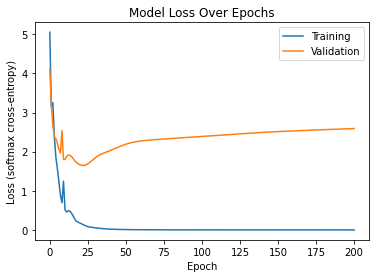

In [66]:
# Plot shows that the fitting process is some what jumpy in initial epochs and 
#  that over time the validation loss becomes worse
#  (One issue here is that features aren't scaled)
train_cora(features, adj, gnn, 32, 200, 0.01)

Epoch 0 | Training loss: 1.9701551 |Train accuracy:  0.7785715 | Val accuracy: 0.238 | Test accuracy: 0.276
Epoch 1 | Training loss: 1.6945965 |Train accuracy:  0.9571429 | Val accuracy: 0.31599998 | Test accuracy: 0.36099997
Epoch 2 | Training loss: 1.4631413 |Train accuracy:  0.99285716 | Val accuracy: 0.38200003 | Test accuracy: 0.415
Epoch 3 | Training loss: 1.2197294 |Train accuracy:  0.99285716 | Val accuracy: 0.438 | Test accuracy: 0.44
Epoch 4 | Training loss: 0.97525036 |Train accuracy:  0.99285716 | Val accuracy: 0.45199996 | Test accuracy: 0.45899996
Epoch 5 | Training loss: 0.7518221 |Train accuracy:  0.99285716 | Val accuracy: 0.47 | Test accuracy: 0.469
Epoch 6 | Training loss: 0.56372505 |Train accuracy:  0.99285716 | Val accuracy: 0.47599998 | Test accuracy: 0.484
Epoch 7 | Training loss: 0.41519052 |Train accuracy:  1.0 | Val accuracy: 0.48399997 | Test accuracy: 0.5
Epoch 8 | Training loss: 0.30373585 |Train accuracy:  1.0 | Val accuracy: 0.494 | Test accuracy: 0.511


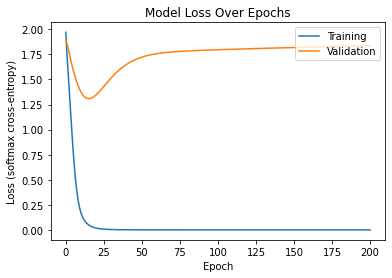

In [67]:
# Replace adjacenvy matrix with identity matrix
# This is equivalent to a perceptron classifier
# Since the graph structure is quite helpful in this case, this model severly over fits
# Also under-performs in terms of accuracy
train_cora(features, tf.eye(adj.shape[0]), gnn, 32, 200, 0.01)

Epoch 0 | Training loss: 1.9481387 |Train accuracy:  0.63571423 | Val accuracy: 0.274 | Test accuracy: 0.326
Epoch 1 | Training loss: 1.7421453 |Train accuracy:  0.75714284 | Val accuracy: 0.39999998 | Test accuracy: 0.45499995
Epoch 2 | Training loss: 1.521834 |Train accuracy:  0.92857146 | Val accuracy: 0.576 | Test accuracy: 0.606
Epoch 3 | Training loss: 1.2810816 |Train accuracy:  0.9571429 | Val accuracy: 0.702 | Test accuracy: 0.738
Epoch 4 | Training loss: 1.0488352 |Train accuracy:  0.9857144 | Val accuracy: 0.76399994 | Test accuracy: 0.7809999
Epoch 5 | Training loss: 0.84311026 |Train accuracy:  0.99285716 | Val accuracy: 0.78800005 | Test accuracy: 0.79899985
Epoch 6 | Training loss: 0.67055357 |Train accuracy:  0.99285716 | Val accuracy: 0.79599994 | Test accuracy: 0.80499977
Epoch 7 | Training loss: 0.52976215 |Train accuracy:  0.99285716 | Val accuracy: 0.79999995 | Test accuracy: 0.8069998
Epoch 9 | Training loss: 0.32400355 |Train accuracy:  0.99285716 | Val accuracy:

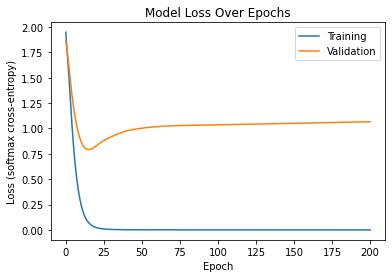

In [68]:
# Divide adjacency matrix by degree matrix (mean-pooling) to help regularize features
# (helps control size of features and results in a more stable fit)
deg = tf.reduce_sum(adj, axis = -1)
train_cora(features, adj/deg, gnn, 32, 200, 0.01)

Epoch 0 | Training loss: 1.9529613 |Train accuracy:  0.77857137 | Val accuracy: 0.482 | Test accuracy: 0.49199998
Epoch 1 | Training loss: 1.7740258 |Train accuracy:  0.85 | Val accuracy: 0.55399996 | Test accuracy: 0.555
Epoch 2 | Training loss: 1.5609983 |Train accuracy:  0.89285713 | Val accuracy: 0.584 | Test accuracy: 0.5749999
Epoch 3 | Training loss: 1.3253117 |Train accuracy:  0.9214286 | Val accuracy: 0.606 | Test accuracy: 0.602
Epoch 4 | Training loss: 1.1044271 |Train accuracy:  0.9357143 | Val accuracy: 0.644 | Test accuracy: 0.642
Epoch 5 | Training loss: 0.9021135 |Train accuracy:  0.9571429 | Val accuracy: 0.704 | Test accuracy: 0.693
Epoch 6 | Training loss: 0.7217886 |Train accuracy:  0.97857153 | Val accuracy: 0.74 | Test accuracy: 0.737
Epoch 7 | Training loss: 0.56759197 |Train accuracy:  0.97857153 | Val accuracy: 0.76199996 | Test accuracy: 0.76599985
Epoch 8 | Training loss: 0.4398041 |Train accuracy:  0.9857144 | Val accuracy: 0.78 | Test accuracy: 0.7809999
Ep

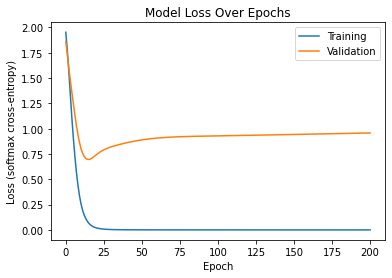

In [69]:
# Thomas Kipf regularization (similar to mean pooling)
norm_deg = tf.linalg.diag(1.0/tf.sqrt(deg))
norm_adj = tf.matmul(norm_deg, tf.matmul(adj, norm_deg))
train_cora(features, norm_adj, gnn, 32, 200, 0.01)